# Download FASHION MNIST dataset using torchvision.datasets
## And apply transforms.Pad and transforms.ToTensor

In [1]:
import os
import pathlib

working_folder = pathlib.Path.cwd()
models_folder = working_folder/ "models"
datasets_folder = pathlib.Path(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\data\fashion")

In [2]:
import torch
from torchvision import datasets, transforms

output_size = (32,32)

# Define the transformation to apply to the dataset
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,),(0.5,))

])

# Load the Fashion MNIST training dataset
train_dataset = datasets.FashionMNIST(
    root=str(datasets_folder),
    train=True,
    download=True,
    transform=transform
)

# Load the Fashion MNIST test dataset
test_dataset = datasets.FashionMNIST(
    root=str(datasets_folder),
    train=False,
    download=True,
    transform=transform
)



In [3]:
type(train_dataset).__mro__

(torchvision.datasets.mnist.FashionMNIST,
 torchvision.datasets.mnist.MNIST,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [4]:
from torch.utils.data import random_split

# Assuming you have defined the `train_dataset` as mentioned in the question

# Define the validation set size (e.g., 20% of the dataset)
validation_size = int(0.2 * len(train_dataset))
training_size = len(train_dataset) - validation_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [training_size, validation_size])


In [5]:
# Create data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
print(f"train_dataset type : {type(train_dataset)}, its length : {len(train_dataset)}")

train_dataset type : <class 'torch.utils.data.dataset.Subset'>, its length : 48000


## Build function to display 10 samples from the dataset

In [7]:
import matplotlib.pyplot as plt

In [35]:
def display_fashion_images(images, n=10, size=(20, 3), cmap="gray_r", as_type=torch.float32, save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    images = images.cpu()
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].to(as_type).squeeze(), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [9]:
import random
batch_no = random.choice(range(len(train_loader)))
batch_no = batch_no if batch_no<10 else 2
for i,(images,labels) in enumerate(train_loader):
  if i==batch_no:
    print(f"images shape : {images.shape}")
    print(f"labels shape : {labels.shape}")
  elif i > batch_no:
    break


images shape : torch.Size([100, 1, 32, 32])
labels shape : torch.Size([100])


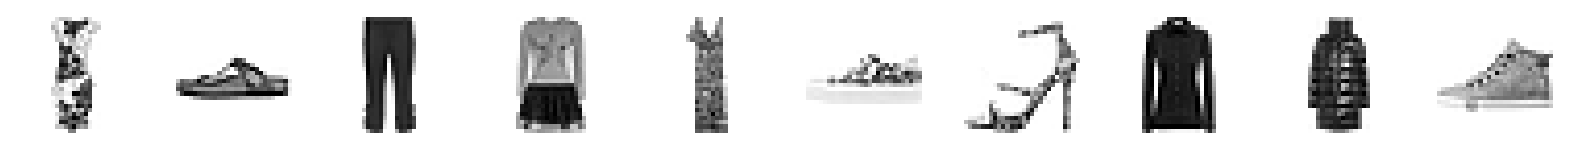

In [10]:
display_fashion_images(images[:10])

# Build the model

## Buid Sampling function

This will be used to sample images from the predicted distribution by the Encoder

In [11]:
import torch
import torch.nn as nn
import pdb

In [12]:
# Sampling module
class Sampling(nn.Module):
  def __init__(self):
    super(Sampling,self).__init__()

  def forward(self,z_mean, z_log_var):
    std = torch.exp(0.5 * z_log_var)
    epsilon = torch.randn_like(std)
    z = z_mean + epsilon * std
    return z

## Build the Encoder
VAE Encoder takes an image, runs it through series of Convolution layers, while downsampling the images and increasing channel size.
In the end it will output a mean and log of variance of a distribution, from which we will sample data and pass it through our decoder to generate an image from the latent space

In [13]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, out_size=4, out_channels=128,embedding_size=2):
    super(Encoder,self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=3,stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

    self.z_mean_fc = nn.Linear(out_size*out_size*out_channels,embedding_size)
    self.z_log_var_fc = nn.Linear(out_size*out_size*out_channels,embedding_size)

    self.relu = nn.ReLU()

  def forward(self, x):
    # pdb.set_trace()
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = torch.flatten(x, start_dim=1)
    z_mean = self.z_mean_fc(x)
    z_log_var = self.z_log_var_fc(x)
    return z_mean, z_log_var

## Build the decoder
The decoder will accept samples from the latent space with predetermined embedding dimension, which is 2 in this case.
It will then pass it through series of Upsampling convolutional layers that will increase spatial size of the input while decreasing the number of channels

In [14]:
# Decoder
class Decoder(nn.Module):
  def __init__(self,inp_channels=128,inp_size=4,embedding_size=2):
    super(Decoder,self).__init__()

    self.inp_channels=inp_channels
    self.inp_size=inp_size
    self.fc1 = nn.Linear(embedding_size, inp_size * inp_size * inp_channels)
    self.convtrns1=nn.ConvTranspose2d(inp_channels, 128, kernel_size=4,stride=2, padding=1)
    self.convtrns2 = nn.ConvTranspose2d(128, 64, kernel_size=4,stride=2, padding=1)
    self.convtrns3 = nn.ConvTranspose2d(64, 32, kernel_size=4,stride=2, padding=1)

    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(32,1,kernel_size=3,padding=1)

  def forward(self,z):
    x = self.fc1(z)
    # pdb.set_trace()
    x = x.view(-1,self.inp_channels,self.inp_size,self.inp_size)
    x = self.relu(self.convtrns1(x))
    x = self.relu(self.convtrns2(x))
    x = self.relu(self.convtrns3(x))
    x = torch.sigmoid(self.conv(x))
    return x

## Construct VAE model

Finally we construct our VAE model which is the combination of encoder and decoder.
It will have encoder, decoder and sampler as its attributes and use them to encode an image into latent space, predict latent space distribution in terms of mean and log of variance
and sample data from the latent distribution and then decode it into an image in an attempt to reproduce the original image.

In [15]:
# VAE
class VAE(nn.Module):
  def __init__(self, encoder, sampling, decoder):
    super(VAE,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.sampling=sampling

  def forward(self,x):
    z_mean, z_log_var = self.encoder(x)
    z = self.sampling(z_mean,z_log_var)
    out = self.decoder(z)
    return out, z_mean, z_log_var

## Defina loss function

Our loss function consists of reconstruction loss and kullback leibler loss components.
Reconstruction loss is quite an obvious criteria as it represents the difference between the original image and reproduced image.
We calculate reconstruction loss using ```torch.nn.functional.binary_cross_entropy```. Here is how to interpret it.
```binary_cross_entropy``` at its core accepts the prediction for a binary class (such as heads or tails) and the target value for the binary class (0 or 1)
When dealing with a binary class, we a are asking a question "What is the odds of class being white?". Target with value 0 will mean it was black, and 1 will mean it was white.
Our prediction will represent the probability of the predicted class being "white".
Now you might ask how this works when comparing two images with shapes (C,H,W). In this case, ```binary_cross_entropy``` will treat every pixel value of reproduced and actual images as probabilities.
Then for every pixel, it will treat pixel values from reconstructed image and target image as the probabilities of that pixel belonging to some imaginary class "A". The actual class is irrevalant. The probabilities being close are relevant. When probabilities are close, our loss will decline.

Next is Kullback-Leibler. KL gives us the metric of how much two distributions differ. When we have two probability distributions with density functions p(x) and q(x), KL is sum((p(x)/q(x)) *p(x)). In our case we will be calculating divergence between Normal distribution with mean of zero and stddev of 1 and the one that our model predicts.
Essentially, we are trying to make our latent distribution to have similar parameters as standard normal distribution.
The formula to calculate KL divergence between two Normal distributions is ()

The Kullback-Leibler (KL) divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. For two normal (Gaussian) distributions, the KL divergence can be calculated using their means (\( \mu_1, \mu_2 \)) and standard deviations (\( \sigma_1, \sigma_2 \)).

The formula for the KL divergence from a normal distribution \( N(\mu_1, \sigma_1^2) \) to another normal distribution \( N(\mu_2, \sigma_2^2) \) is given by:

$$
KL(N(\mu_1, \sigma_1^2) \, || \, N(\mu_2, \sigma_2^2)) = \log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
$$

In this formula:
- \( \log \) is the natural logarithm.
- \( \sigma_1 \) and \( \sigma_2 \) are the standard deviations of the first and second distributions, respectively.
- \( \mu_1 \) and \( \mu_2 \) are the means of the first and second distributions, respectively.

This formula quantifies the amount of information lost when \( N(\mu_1, \sigma_1^2) \) is used to approximate \( N(\mu_2, \sigma_2^2) \). It's important to note that KL divergence is not symmetric; that is, \( KL(N(\mu_1, \sigma_1^2) \, || \, N(\mu_2, \sigma_2^2)) \) is generally not equal to \( KL(N(\mu_2, \sigma_2^2) \, || \, N(\mu_1, \sigma_1^2)) \).

In [16]:
# Loss function
def loss_fn(reconst, data, z_mean, z_log_var, BETA = 500):
  # pdb.set_trace()
  reconst_loss = torch.mean(BETA * torch.nn.functional.binary_cross_entropy(reconst, data, reduction='none').sum(dim=(1,2,3)))
  kl_loss = torch.mean(-0.5 * torch.sum(1+z_log_var-z_mean.pow(2)-z_log_var.exp(),dim=1))
  total_loss = reconst_loss + kl_loss
  return total_loss, reconst_loss, kl_loss

In [17]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [19]:
from tqdm import tqdm

In [20]:
# calculate loss
def compute_loss(model,data_loader, BETA=500):
  model.eval()

  total_loss = 0
  num_samples = 0

  with torch.no_grad():
    for images,labels in tqdm(data_loader,position=0,desc="Val Loss compute"):
      images = images.to(device)
      reconst,z_mean,z_log_var = model(images)
      loss, reconst_loss, kl_loss = loss_fn(reconst, images, z_mean, z_log_var, BETA=BETA)

      total_loss += loss.item()
      num_samples +=images.size(0)
  avg_loss = total_loss / num_samples
  model.train()
  return avg_loss

In [21]:


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, test_loader):
  """
  train loop
  """
  best_val_loss = float('inf')
  train_losses = []
  val_losses = []
  test_losses = []
  for epoch in tqdm(range(1, n_epochs+1), position=0, desc="Epoch loop"):
    loss_train = 0
    for images, labels in tqdm(train_loader, position=0, desc="Within epoch iterations"):
      images = images.to(device=device)
      labels = images.to(device=device)
      reconst, z_mean, z_log_var = model(images)

      total_loss, reconst_loss, kl_loss = loss_fn(reconst,images,z_mean,z_log_var)
      train_losses.append({"total":total_loss.item(),"reconst":reconst_loss.item(),"kl":kl_loss.item()})

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      loss_train += total_loss.item()

    loss_train_avg = loss_train / len(train_loader)

    print(f"Epoch {epoch} average train loss : {loss_train_avg}")

    with torch.no_grad():
      val_loss = compute_loss(model,val_loader)

      if val_loss < best_val_loss:
        best_val_loss = val_loss

        print(f"epoch {epoch}, saving vae model with best loss of {best_val_loss}")
        torch.save(model.state_dict(),str(models_folder/f"vae_pytorch_best.pt"))
  return train_losses

In [22]:
embedding_size = 2
encoder_out_size = 4
encoder_out_channels = 128
sampling = Sampling()
encoder = Encoder(out_size=encoder_out_size,out_channels=encoder_out_channels)
decoder = Decoder(inp_channels=encoder_out_channels,inp_size=encoder_out_size)
vae = VAE(encoder,sampling,decoder)


In [23]:
import torch.optim as optim

In [26]:
vae = vae.to(device)

In [27]:
n_epochs=5

learning_rate = 0.0005

optimizer = optim.Adam(vae.parameters(), lr = learning_rate)

train_losses = training_loop(n_epochs,optimizer,vae,loss_fn,train_loader,val_loader,test_loader)

Within epoch iterations: 100%|██████████| 480/480 [00:07<00:00, 63.60it/s] 


Epoch 1 average train loss : 156698.57919921874


Epoch loop:  20%|██        | 1/5 [00:08<00:33,  8.26s/it]

epoch 1, saving vae model with best loss of 1356.932451171875


Within epoch iterations: 100%|██████████| 480/480 [00:04<00:00, 107.11it/s]


Epoch 2 average train loss : 133769.76860351564


Epoch loop:  40%|████      | 2/5 [00:13<00:19,  6.46s/it]

epoch 2, saving vae model with best loss of 1322.1196848958334


Within epoch iterations: 100%|██████████| 480/480 [00:04<00:00, 107.27it/s]


Epoch 3 average train loss : 131233.83198242186


Epoch loop:  60%|██████    | 3/5 [00:18<00:11,  5.89s/it]

epoch 3, saving vae model with best loss of 1304.6739954427082


Within epoch iterations: 100%|██████████| 480/480 [00:04<00:00, 105.64it/s]


Epoch 4 average train loss : 129986.84401041667


Epoch loop:  80%|████████  | 4/5 [00:23<00:05,  5.65s/it]

epoch 4, saving vae model with best loss of 1293.6714661458334


Within epoch iterations: 100%|██████████| 480/480 [00:04<00:00, 106.93it/s]


Epoch 5 average train loss : 129089.10913085938


Epoch loop: 100%|██████████| 5/5 [00:29<00:00,  5.83s/it]

epoch 5, saving vae model with best loss of 1288.0764029947916


In [28]:
train_total_losses=[item['total'] for item in train_losses]
train_reconst_losses=[item['reconst'] for item in train_losses]
train_kl_losses=[item['kl'] for item in train_losses]
print(f"length of train_losses : {len(train_losses)}")

length of train_losses : 2400


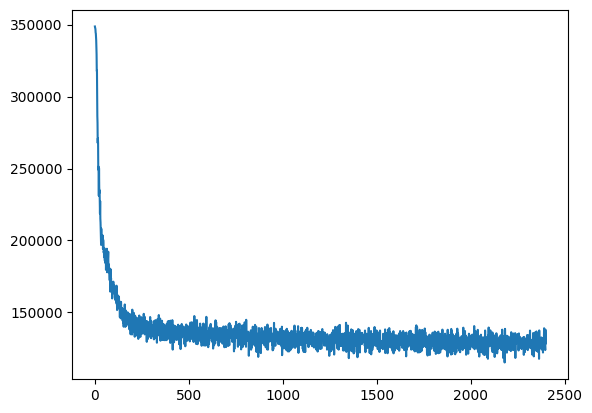

In [29]:
plt.plot(train_total_losses)
plt.show()

In [37]:
import random
batch_no = random.randint(1,len(train_loader))
print(f"picked up batch number : {batch_no}/{len(train_loader)}")
for i,(images,labels) in enumerate(train_loader):
  if i==batch_no:
    print(f"images shape : {images.shape}")
    print(f"labels shape : {labels.shape}")
  elif i > batch_no:
    break



picked up batch number : 150/480
images shape : torch.Size([100, 1, 32, 32])
labels shape : torch.Size([100])


In [38]:
images = images[:10]
images = images.to(device)
with torch.no_grad():
  reconst,z_mean,z_log_var = vae(images)

In [40]:
with torch.no_grad():
  z_mean,z_log_var=encoder(images)
  print(f"z_mean output shape : {z_mean.shape}")
  z = sampling(z_mean,z_log_var)
  print(f"z shape : {z.shape}")

z_mean output shape : torch.Size([10, 2])
z shape : torch.Size([10, 2])


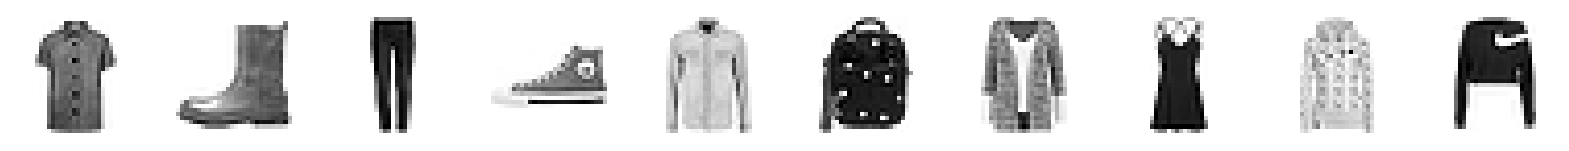

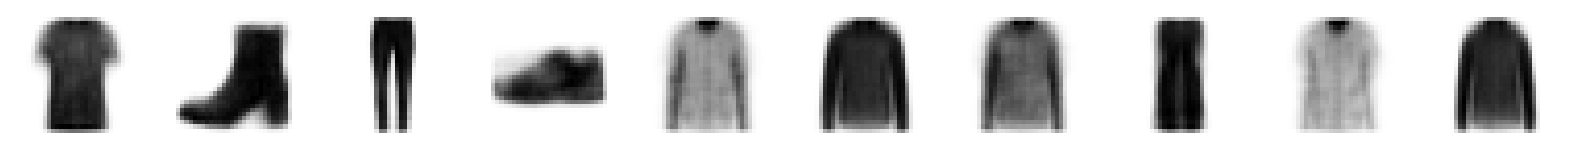

In [41]:
display_fashion_images(images)
display_fashion_images(reconst)

# Let's try generating images from latent dimension

In [42]:
shirt_encoding = torch.tensor([-0.59,0.24])
print(shirt_encoding.shape)
shirt_encoding = shirt_encoding.unsqueeze(0)
print(shirt_encoding.shape)

torch.Size([2])
torch.Size([1, 2])


IndexError: index 1 is out of bounds for dimension 0 with size 1

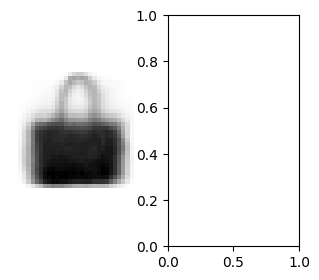

In [46]:
shirt_encoding = shirt_encoding.to(device)
with torch.no_grad():
  shirt_reconst = decoder(shirt_encoding)  
  display_fashion_images(shirt_reconst)

In [45]:
shirt_reconst.shape

torch.Size([1, 1, 32, 32])